In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm

uplifted = pd.read_csv('../data/peaks.min_peak_score_0.6.thresh_0.5.csv', index_col=0)
# uplifted.drop('Unnamed: 0', inplace=True, axis=1)
uplifted = uplifted[uplifted.chrom == 'chr1'].copy()
print(uplifted.shape)
uplifted.tail(2)

(93843, 5)


/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,chrom,start,end,peak_pos,score
93843,chr1,249231725,249231752,249231739,0.63
93844,chr1,249232614,249232644,249232636,0.88


In [2]:
df = pd.read_csv('../data/chr1.S15-30.filtered.csv', index_col=0, dtype='int')
print(df.shape)
df.tail(2)

(6743736, 4)


/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,start,end,len_stem,len_loop
10941422,249239532,249239564,16,4
10941426,249239644,249239681,17,7


In [ ]:
def make_n_bp(df, uplifted, n=70):
        """
Return all 'df' elements where end in 10-70 range before start of 'uplifted' 
    :param df: sec. struct. df with columns start   end len_stem    len_loop (10941426 rows)
    :param uplifted: nucleosome df with columns chrom   start   end peak_pos    score (1037956 rows)
    """
    df1 = df.sort_values('end').reset_index(drop=True)

    # getting indexes where should df.end be, if inserted into uplifted (nucl array)
    indxes = np.searchsorted(uplifted.start.values, df1.end.values)

    uplifted1 = uplifted.append(uplifted.tail(1))  # for df.end > uplifted.start.max()

    uplifted_ind = uplifted1.iloc[indxes].reset_index(drop=True)  # getting all uplifted.start closest to df.end 
    uplifted_ind['df_end'] = df1.end.values
    uplifted_ind['diff'] = uplifted_ind.start - uplifted_ind.df_end
    mask = (uplifted_ind['diff'] >= 0) & (uplifted_ind['diff'] < n)
    return df1[mask].reset_index(drop=True)
ss10bp = make_n_bp(df, uplifted)

In [ ]:
def add_bp_according2_start_end(neg_example):
    """
adds nucleotides string according to start-end columns
    :param neg_example: DataFrame with start-end columns
    """
    from Bio import SeqIO
    first_record = str(next(SeqIO.parse("/home/shared/hg19/chr1.fna", "fasta")).seq)

    temp = pd.DataFrame(np.ndarray((neg_example.shape[0], 4)),
                        columns=["struct", "before", "after", 'half_struct'], dtype='str')
    for idx, row in neg_example.iterrows():
        temp.loc[idx][0] = first_record[row['start']:row['end']]
        temp.loc[idx][1] = first_record[row['start'] - 20:row['start']]
        temp.loc[idx][2] = first_record[row['end']:row['end']    + 20]
        temp.loc[idx][3] = first_record[row['start']:row['start'] + (row['end'] - row['start'])//2]

    return pd.concat([neg_example, temp], axis=1)

ss10bp = add_bp_according2_start_end(ss10bp)
ss10bp.head()

In [ ]:
neg_example = df.sample(15000).reset_index()

from Bio import SeqIO
first_record = str(next(SeqIO.parse("/home/shared/hg19/chr1.fna", "fasta")).seq)

temp = pd.DataFrame(np.ndarray((neg_example.shape[0], 4)), columns=["struct", "before", "after", 'half_struct'], dtype='str')
for idx, row in neg_example.iterrows():
    temp.loc[idx][0] = first_record[row['start']:row['end']]
    temp.loc[idx][1] = first_record[row['start'] - 20:row['start']]
    temp.loc[idx][2] = first_record[row['end']:row['end']    + 20] 
    temp.loc[idx][3] = first_record[row['start']:row['start'] + (row['end'] - row['start'])//2]

neg_example = pd.concat([neg_example, temp], axis=1)
neg_example.head(2)

In [ ]:
neg_example['value'] = 0
ss10bp['value'] = 1
concated = pd.concat([neg_example, ss10bp], ignore_index=True)
concated.tail(2)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import re
from MulticoreTSNE import MulticoreTSNE as TSNE  # https://github.com/DmitryUlyanov/Multicore-TSNE
concated.isnull().sum()

In [ ]:
diprodb = pd.read_csv('../data/dprops.csv', index_col=0)

features = []
for struct in tqdm(concated.loc[:, concated.columns != 'value']['struct']):
    strl = re.findall('..', struct)
    temp = []
    for dyad in strl:
        temp.append(diprodb[diprodb['PropertyName'] == dyad].values.tolist()[0])
    features.append(pd.DataFrame(temp, columns=diprodb.columns).sum())
features = pd.DataFrame(features)
features.tail()

In [ ]:
cumsum_arr = np.zeros((1000))

for peak_pos in tqdm(pd.to_numeric(uplifted.peak_pos)):
    temp_df = df[(df['start'] > peak_pos - 500) & (df['end'] < peak_pos + 500)]
    for ind, row in temp_df.iterrows():
        for i in range(int(row['start']) - peak_pos + 500, int(row['end']) - peak_pos + 500):
            cumsum_arr[i] += 1
# cumsum_arr

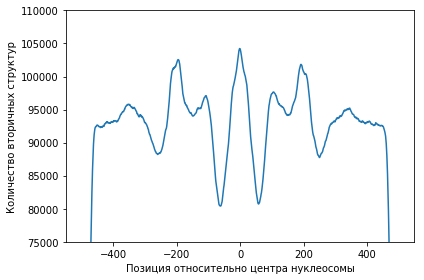

In [18]:
x = np.arange(-500, 500)
plt.plot(x, cumsum_arr)
plt.ylabel('Количество вторичных структур')
plt.xlabel('Позиция относительно центра нуклеосомы')
plt.ylim(75000, 110000)
plt.tight_layout()
plt.savefig('../pictures/chr1_S16-50_nucleosome-centered.png')

In [ ]:
uplifted.tail()

In [ ]:
# tsne = TSNE(n_jobs=8)
# transformed = tsne.fit_transform(features.loc[:, features.columns != 'PropertyName'])
# vis_x = transformed[:, 0]
# vis_y = transformed[:, 1]
# plt.scatter(vis_x, vis_y, c=concated['value'].map({0: 'blue', 1: 'orange'}))
# # plt.clim(-0.5, 9.5)
# plt.show()

In [ ]:
csv_feats = pd.concat([features, concated['value']], axis=1, ignore_index=True)
csv_feats.columns = features.columns.tolist() + ['target']

In [ ]:
csv_feats.to_csv('../data/features_df_70bp.csv', index=False)

In [ ]:
csv_feats = pd.read_csv('../data/features_df_70bp.csv')
csv_feats

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    csv_feats.drop(['PropertyName', 'target'], axis=1).values, csv_feats['target'].values,
    test_size=0.2)

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=-1)
logreg.fit(x_train, y_train)

y_pred = logreg.predict_proba(x_test)[:, 1]

In [11]:
from sklearn.metrics import roc_auc_score, r2_score
print(roc_auc_score(y_test, y_pred))
print(r2_score(y_test, y_pred))

0.5722438983477709
0.004077317003306824


In [14]:
import lightgbm as lgb
import telepyth # push notif in telegram
%telepyth -t 1260389131217015787
from sklearn.metrics import roc_auc_score
%load_ext wurlitzer
verbose = 1
plot = 1
params = {
#     "max_bin": 1024,
    "learning_rate": 0.01,
    "boosting_type": "goss",
    "objective": "binary",
    'num_iterations':10000,
    "metric": "auc",
    "num_leaves": 10000,
    "verbose": 1,
#     "min_data": 100,
#     "boost_from_average": True
}

d_train = lgb.Dataset(x_train, y_train)
# d_valid = lgb.Dataset(X_test, label=y_test)
model = lgb.train(params, d_train)
# model.save_model('regressin')
# model = lgb.Booster(model_file='regressin')

y_pred = model.predict(x_test)
print(roc_auc_score(y_test, y_pred))

df_fi = pd.DataFrame(features.columns[1:], columns=['feature'])
df_fi['importance'] = list(model.feature_importance('gain'))
df_fi.sort_values('importance', ascending=False, inplace=True)
# print(df_fi)
if plot:
    plt.figure()
    df_fi.head(10).plot(kind='barh', x='feature', y='importance')
    plt.title('Roc_auc is {}'.format(roc_auc_score(y_test, y_pred)))
    plt.xlabel('relative importance')
    plt.show()

%telepyth 'lgb! \n'

Use token 1260389131217015787.
/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-b615db5e1cc4>", line 23, in <module>
    model = lgb.train(params, d_train)
  File "/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/lightgbm/engine.py", line 201, in train
    booster.update(fobj=fobj)
  File "/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/lightgbm/basic.py", line 1521, in update
    ctypes.byref(is_finished)))
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1828, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no att

KeyboardInterrupt: 

In [ ]:
all_quad_coords = pd.read_csv('/home/konovalovdmitry/results/all_quad_coords.tsv', sep='\t', header=None)
all_quad_coords = all_quad_coords[all_quad_coords[0] == 'chr1']
cols = ['chr', 'start', 'end']
all_quad_coords.columns = cols
df = all_quad_coords.copy()
df.head()

In [ ]:
quadparser = pd.read_csv('/home/konovalovdmitry/results/fna/chr1.qp', sep='\t').reset_index()
# pd.DataFrame(quadparser['level_0'].str.split('-').values.tolist(), columns=['start', 'end'])
quadparser.drop(quadparser.tail(1).index, inplace=True)
df_str = pd.DataFrame(quadparser['level_0'].str.split('-').values.tolist(), columns=['start', 'end'])
df_str.drop(df_str[df_str['start'] == 'Found 10206:5547:5196 overlapping:sequences:lines'].index, inplace=True)
df_str = df_str.astype(int)
df = pd.concat([quadparser['chr1'], df_str], axis=1)


In [ ]:
cumsum_arr = np.zeros(1000)

for peak_pos in tqdm(pd.to_numeric(uplifted.peak_pos)):
    temp_df = df[(df['start'] > peak_pos - 500) & (df['end'] < peak_pos + 500)]
    for ind, row in temp_df.iterrows():
        for i in range(int(row['start']) - peak_pos + 500, int(row['end']) - peak_pos + 500):
            cumsum_arr[i] += 1
# cumsum_arr

x = np.arange(-500, 500)
plt.plot(x, cumsum_arr)
plt.ylabel('Number of sec. structures')
plt.xlabel('Centered position')

In [ ]:
def make_10bp(df, uplifted):
    """
Выделить все структуры, у которых основание ножки находятся на расстоянии от 0 до 10 нуклеотидов от границы нуклеосомы.
    :param df: sec. struct. df
    :param uplifted: nucleosome df
    """
    arr_4_rows = []
    for start_upl in tqdm(pd.to_numeric(uplifted.start)):
        temp_df = df[(df['end'] > start_upl - 10) & (df['end'] < start_upl)]
        if not temp_df.empty:
            for ind, row in temp_df.iterrows():
                arr_4_rows.append(row)
    ss10bp = pd.DataFrame(arr_4_rows)
#     ss10bp.to_csv('sec_struct_0-10bp_to_nucleosome.csv', index=False)
    return ss10bp

quad10bp = make_10bp(df, uplifted)

In [ ]:
print(quad10bp.shape[0] / all_quad_coords.shape[0] * 100)

In [ ]:
quad10bp[['start', 'end']] = quad10bp[['start', 'end']].astype(int)
quad10bp = quad10bp.reset_index(drop=True)

5% out of all quadruplexes are near nucleosomes

In [ ]:

def make_go_terms(ss10bp, suffix='quad'):
    """
makes go_terms.csv for pasting to http://revigo.irb.hr/ and getting genes and their types
also makes relevant_goa_names.csv for names of this genes
    :return:
    """
    ptt = pd.read_csv('../data/ptt_hg19.txt', delimiter='\t')
    ptt1 = ptt[ptt['chrom'] == 'chr1']

    def make_10bp_pr(df, uplifted):
        arr_4_rows = []
        for start_upl in tqdm(pd.to_numeric(uplifted.end)):
            temp_df = df[(df['txStart'] - 1000 < start_upl) & (df['txEnd'] > start_upl) & (df.strand == '+')]
            if not temp_df.empty:
                for ind, row in temp_df.iterrows():
                    arr_4_rows.append(row)
        return pd.DataFrame(arr_4_rows)

    relevant_ptt = make_10bp_pr(ptt1, ss10bp)

    goa = pd.read_csv('../data/goa_human.gaf', delimiter='\t', header=None)

    relevant_goa = goa[goa[1].isin(relevant_ptt.proteinID)].drop_duplicates(1)
    relevant_goa[9].to_csv('../data/relevant_goa_names_{}.csv'.format(suffix))
    relevant_goa[4].to_csv('../data/go_terms_{}.csv'.format(suffix), index=False)

make_go_terms(quad10bp)

In [ ]:
def add_bp_according2_start_end(neg_example):
    """
adds nucleotides string according to start-end columns
    :param neg_example: DataFrame with start-end columns
    """
    from Bio import SeqIO
    first_record = str(next(SeqIO.parse("/home/shared/hg19/chr1.fna", "fasta")).seq)

    temp = pd.DataFrame(np.ndarray((neg_example.shape[0], 4)),
                        columns=["struct", "before", "after", 'half_struct'], dtype='str')
    for idx, row in neg_example.iterrows():
        temp.loc[idx][0] = first_record[row['start']:row['end']]
        temp.loc[idx][1] = first_record[row['start'] - 20:row['start']]
        temp.loc[idx][2] = first_record[row['end']:row['end']    + 20]
        temp.loc[idx][3] = first_record[row['start']:row['start'] + (row['end'] - row['start'])//2]

    return pd.concat([neg_example, temp], axis=1)

quad10with_bps = add_bp_according2_start_end(quad10bp)


In [ ]:
neg_example = all_quad_coords.sample(5000).reset_index(drop=True)
neg_example = add_bp_according2_start_end(neg_example)
neg_example['value'] = 0
quad10with_bps['value'] = 1
quad10with_bps.drop('chr1', inplace=True, axis=1)
neg_example.drop('chr', inplace=True, axis=1)
concated = pd.concat([neg_example, quad10with_bps])
concated.head(2)

In [ ]:
concated.tail()

In [ ]:
def calc_feats(concated, position='half_struct'):
    """
calculate features from diprodb
    :param position: struct, before, after or half_struct
    :param concated: df with bp as after add_bp_according2_start_end
    """
    diprodb = pd.read_csv('../data/dprops.csv', index_col=0)
    import re
    features = []
    for struct in tqdm(concated.loc[:, concated.columns != 'value'][position]):
        strl = re.findall('..', struct)
        temp = []
        for dyad in strl:
            temp.append(diprodb[diprodb['PropertyName'] == dyad].values.tolist()[0])
        features.append(pd.DataFrame(temp, columns=diprodb.columns).sum())
    return pd.DataFrame(features)
feats = calc_feats(concated)

In [ ]:
feats.head(2).append(feats.tail(2))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import re
from MulticoreTSNE import MulticoreTSNE as TSNE  # https://github.com/DmitryUlyanov/Multicore-TSNE


def plot_tsne(ss10bp, position='struct'):
    """
form  physical features dataframe and use t-sne on it
https://lvdmaaten.github.io/tsne/
    :param position: before, after or struct for position relative to structure
    :param ss10bp: see preprocessing.py, sec. structs within 10bp from nucleosome
    :return: plt for plt.show()
    """
    diprodb = pd.read_csv('../data/dprops.csv', index_col=0)

    features = []
    for struct in tqdm(ss10bp[position]):
        strl = re.findall('..', struct)
        temp = []
        for dyad in strl:
            temp.append(diprodb[diprodb['PropertyName'] == dyad].values.tolist()[0])
        features.append(pd.DataFrame(temp, columns=diprodb.columns).sum())
    features = pd.DataFrame(features)


    tsne = TSNE(n_jobs=8)
    transformed = tsne.fit_transform(features.loc[:, features.columns != 'PropertyName'])

    vis_x = transformed[:, 0]
    vis_y = transformed[:, 1]

    plt.scatter(vis_x, vis_y, cmap=plt.cm.get_cmap("jet", 10))
    plt.clim(-0.5, 9.5)
    return plt
    # plt.show()
    # or we can do this and label relevant vs random
    # diprodb = pd.read_csv('../data/dprops.csv', index_col=0)
    #
    # features = []
    # for struct in tqdm(concated.loc[:, concated.columns != 'value']['before']):
    #     strl = re.findall('..', struct)
    #     temp = []
    #     for dyad in strl:
    #         temp.append(diprodb[diprodb['PropertyName'] == dyad].values.tolist()[0])
    #     features.append(pd.DataFrame(temp, columns=diprodb.columns).sum())
    # features = pd.DataFrame(features)
    #
    # tsne = TSNE(n_jobs=8)
    # transformed = tsne.fit_transform(features.loc[:, features.columns != 'PropertyName'])
    #
    # vis_x = transformed[:, 0]
    # vis_y = transformed[:, 1]
    #
    # plt.scatter(vis_x, vis_y, c=concated['value'].map({0: 'blue', 1: 'orange'}))
    # # plt.clim(-0.5, 9.5)
    # plt.show()



In [ ]:
plot_tsne(quad10with_bps)

In [ ]:

tsne = TSNE(n_jobs=8)
transformed = tsne.fit_transform(feats.loc[:, feats.columns != 'PropertyName'])

vis_x = transformed[:, 0]
vis_y = transformed[:, 1]

plt.scatter(vis_x, vis_y, c=concated['value'].map({0: 'blue', 1: 'orange'}))
# plt.clim(-0.5, 9.5)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    feats.drop('PropertyName', axis=1).values, concated['value'].values,
    test_size=0.3)
%load_ext wurlitzer  
import telepyth # push notif in telegram

%telepyth -t 1260389131217015787

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
np.random.seed(42)
verbose = 1
plot = 1
params = {
#     "max_bin": 1024,
#     "learning_rate": 0.01,
    "boosting_type": "goss",
    "objective": "binary",
#     'num_iterations':10000,
    "metric": "auc",
#     "num_leaves": 10000,
    "verbose": 1,
#     "min_data": 100,
#     "boost_from_average": True,
    'early_stopping_round': 50
}

d_train = lgb.Dataset(x_train, y_train)
d_valid = lgb.Dataset(x_test, label=y_test)
model = lgb.train(params, d_train, valid_sets=d_valid)
# model.save_model('regressin')
# model = lgb.Booster(model_file='regressin')

y_pred = model.predict(x_test)
print(roc_auc_score(y_test, y_pred))

In [ ]:
df_fi = pd.DataFrame(features.columns[1:], columns=['feature'])
df_fi['importance'] = list(model.feature_importance('gain'))
df_fi.sort_values('importance', ascending=False, inplace=True)
# print(df_fi)
if plot:
    plt.figure()
    df_fi.head(10).plot(kind='barh', x='feature', y='importance')
    plt.title('Roc_auc is {}'.format(roc_auc_score(y_test, y_pred)))
    plt.xlabel('relative importance')
    plt.show()

%telepyth 'lgb! \n'

In [ ]:
feats['Tilt_shift']